# 第３章

## スペクトル半径と非線形性

ここでは、リザバーが持つスペクトル半径とそれに伴った非線形性がどのような関係にあるかを実際にプロットしながら確かめていく。

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt

from reservoir_network.network import EchoStateNetwork

%matplotlib inline

In [26]:
params = {
    "d_in": 1,
    "d_hidden": 100,
    "d_out": 1,
    "density": 0.2,
    "rho_w": 0.999
}
network = EchoStateNetwork(**params)

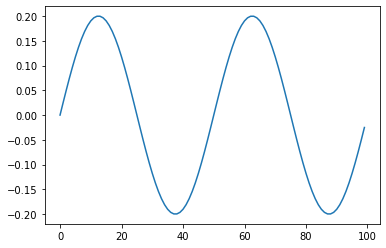

In [27]:
T = 100
L = 50
t = np.arange(T)
input_data = np.sin(t * 2 * np.pi / L) / 5.0
plt.plot(input_data)

In [28]:
network.x_state = None
# input_data = np.random.randn(500, 1, 1)
input_data = input_data.reshape([T, 1, 1])
record_x = np.zeros([T, params["d_hidden"]])
for step, x in enumerate(input_data):
    network.step_forward(x, leak_rate=0.0)
    record_x[step] = network.x_state.copy().flatten()

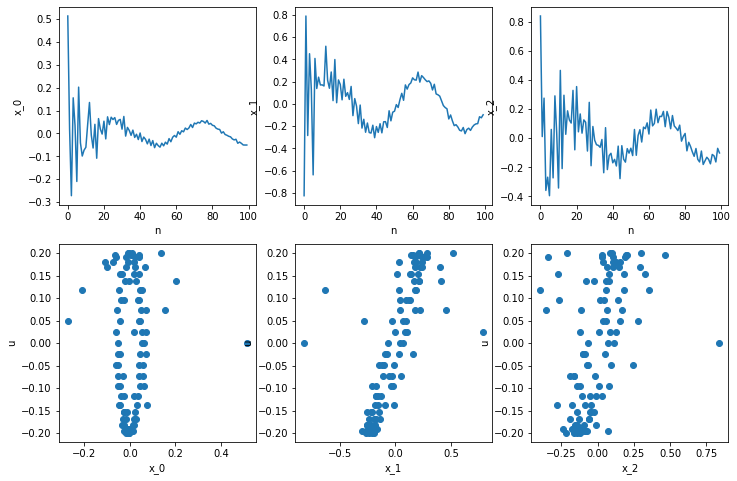

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(3):
    axes[0][i].plot(record_x[:, i])
    axes[0][i].set_xlabel("n")
    axes[0][i].set_ylabel(f"x_{i}")
                          
    
    axes[1][i].scatter(record_x[:, i], input_data.flatten())
    axes[1][i].set_xlabel(f"x_{i}")
    axes[1][i].set_ylabel("u")

入力に従って値が徐々に振動していく様子も確認できた。  
また、rho_wが1.5に大きく設定すると `u` と `x_0` との間に非線形的な関係が生まれるのも確認できた。

## カオスの縁(Edge of chaos)

スペクトル半径が変化するごとにどのようにカオス性が変わっていくかをチェックする。  

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt

from reservoir_network.network import EchoStateNetwork

%matplotlib inline

In [2]:
rho_w_list = np.linspace(0.00, 2.00, 100)

T = 2000
L = 50
t = np.arange(T)
input_data = np.sin(t * 2 * np.pi / L)
input_data = input_data.reshape(T, 1, 1)

ps_list = []
for rho_w in rho_w_list:
    params = {
        "d_in": 1,
        "d_hidden": 100,
        "d_out": 1,
        "density": 0.2,
        "rho_w": rho_w
    }
    network = EchoStateNetwork(**params)
    ps = np.zeros([T//L, 100])
    for _t in range(T):
        network.step_forward(input_data[_t], leak_rate=0.0)
        if _t % L == 0:
            ps[_t // L] = network.x_state.copy()
    ps_list.append(ps[np.newaxis, ...])
ps_list = np.concatenate(ps_list, axis=0)

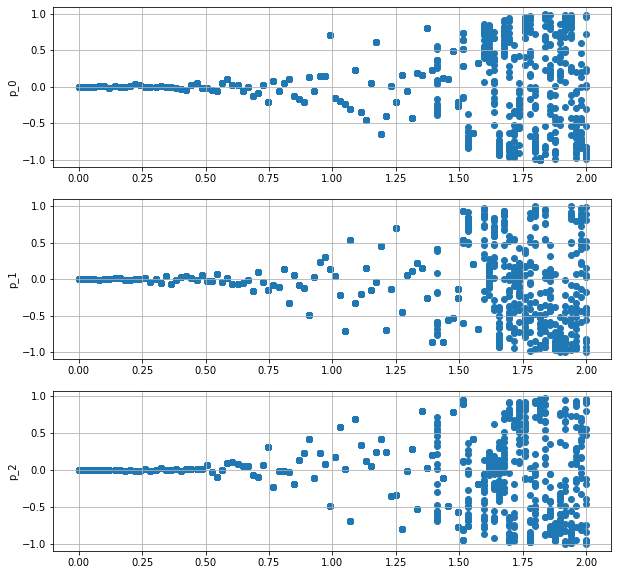

In [3]:
rho_w_values = np.tile(rho_w_list.reshape(-1, 1), (1, T//L//2)).flatten()

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for i in range(3):
    axes[i].scatter(rho_w_values, ps_list[:, 20:, i].flatten())
    axes[i].set_ylabel(f"p_{i}")
    axes[i].grid()

## 遅延タスクと記憶容量

ラグのある時系列データを再現できるかどうかのタスクを解く。これを用いてネットワークの記憶容量を計測する。

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt

from reservoir_network.network import EchoStateNetwork

%matplotlib inline

In [69]:
T = 1000
d_hidden = 100
rho_w = 0.95
input_vectors = np.random.randn(T, 1, 1)
params = {
    "d_in": 1,
    "d_hidden": d_hidden,
    "d_out": 1,
    "density": 0.2,
    "rho_w": 0.95
}
network = EchoStateNetwork(**params)

In [76]:
k = 8

output_vectors = input_vectors[:-k].reshape(-1, 1)
record_states, record_outputs = network.take_steps(input_vectors, num_steps=T, leak_rate=0.0)

record_states = record_states[k:].reshape(-1, d_hidden)

inverse_matrix = np.linalg.inv(np.dot(record_states.T, record_states))

trained_w_out = np.dot(output_vectors.T, np.dot(record_states, inverse_matrix)).T

Determinant coefficient : 0.4740493267588695


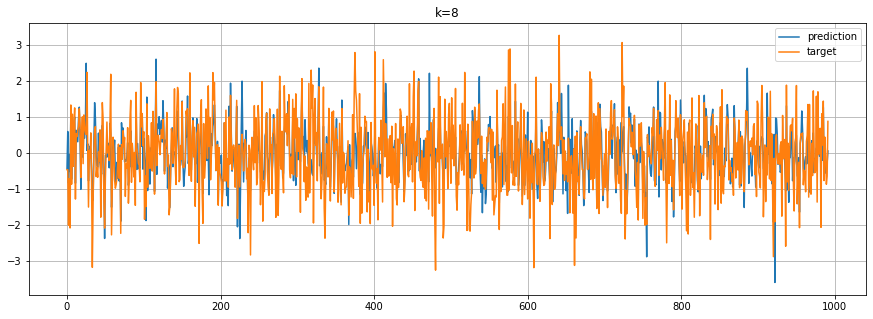

In [77]:
input_vectors = np.random.randn(T, 1, 1)
network.w_out = trained_w_out

record_states, record_outputs = network.take_steps(input_vectors, num_steps=T, leak_rate=0.0)

print("Determinant coefficient :", determination_coefficient(record_outputs[k:, 0, 0], input_vectors[:-k, 0, 0]))
plt.figure(figsize=(15, 5))
plt.title(f"k={k}")
plt.plot(record_outputs[k:, 0, 0], label="prediction")
plt.plot(input_vectors[:-k, 0, 0], label="target")
plt.legend()
plt.grid()

In [2]:
def determination_coefficient(seq0, seq1):
    """決定係数を計算する
    
    Parameters
    ----------
    seq0: np.ndarray
        (T,) の1次元配列
    seq1: np.ndarray
        (T,) の1次元配列
    """
    return np.cov(seq0, seq1)[0, 1]**2 / (np.var(seq0)*np.var(seq1))

In [3]:
def train_network(network, input_vectors, desired_outputs, offset=8, T=100):
    """線形回帰を使ってネットワークを訓練させる"""
    record_states, record_outputs = network.take_steps(input_vectors, num_steps=T, leak_rate=0.0)
    record_states = record_states[offset:].reshape(-1, network.d_hidden)
    
    inverse_matrix = np.linalg.inv(np.dot(record_states.T, record_states))
    trained_w_out = np.dot(desired_outputs.T, np.dot(record_states, inverse_matrix)).T

    network.update_readout(trained_w_out)

In [6]:
def calc_memory_capacity(max_k=20, rho_w=0.95, d_hidden=100, T=1000):
    """記憶容量を測定する"""
    params = {
        "d_in": 1,
        "d_hidden": d_hidden,
        "d_out": 1,
        "density": 0.2,
        "rho_w": 0.95
    }
    network = EchoStateNetwork(**params)
    r_value_list = []
    for k in range(max_k):
        input_vectors = np.random.randn(T, 1, 1)
        if k > 0:
            desired_outputs = input_vectors[:-k].reshape(-1, 1)
        else:
            desired_outputs = input_vectors.reshape(-1, 1)
        train_network(network, input_vectors, desired_outputs, offset=k, T=T)

        test_input_vectors = np.random.randn(T, 1, 1)
        record_states, record_outputs = network.take_steps(test_input_vectors, num_steps=T, leak_rate=0.0)

        if k > 0: 
            r_2 = determination_coefficient(record_outputs[k:, 0, 0], test_input_vectors[:-k, 0, 0])
        else:
            r_2 = determination_coefficient(record_outputs[:, 0, 0], test_input_vectors[:, 0, 0])
        r_value_list.append(r_2)
    return r_value_list

10.294274117275432


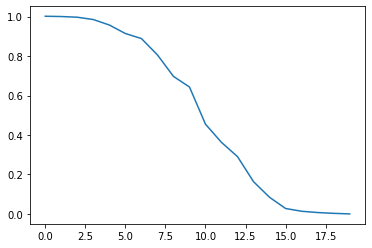

In [9]:
r_value_list = calc_memory_capacity(max_k=20, rho_w=0.8, d_hidden=500, T=1000)


plt.plot(r_value_list)

print(np.sum(r_value_list))